In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema

import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:5'

FREERUN = 20  # Extra predicition time-steps after test data
deltaT = .02      # Number of extra free-running steps  int(20/.02) 

rho = 28.0
sigma = 10.0
beta = 8/3

# Lorenz 1963
def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]             # Initial point
t = np.arange(0,300+FREERUN,deltaT)  # Total of 320 full steps with deltaT=.02
states = odeint(f,state0,t)

mu = np.mean(states, axis=0)       # Get mean for each of x,y,z
signal = (states - mu)[:,[0,1,2]]  # Mean center the data
M = signal.shape[0] - int(FREERUN/deltaT)  # Length of train plus test... no freerun
K = 3                                  # Input dimension
L = 3                                  # Output dimension
RF = .5                                # For feedback <--- not implemented
TEST = 1000                            # length of test
LEAD = 100                            # Number of points to plot before test
BURNIN = 100                           # Number of steps ignored for random x0 to fade
REG = 1e-8                             # Regularization factor for ridge regression
TRAINLENGTH = M-TEST    

MINMAXS = np.max(signal[:TRAINLENGTH+TEST],axis=0)-np.min(signal[:TRAINLENGTH+TEST],axis=0)
RGS = [(-19.5,19.5),(-27,27),(-25,25)]
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [2]:
np.save('./Targets/L3Dsignal', signal)

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

## Training Loop for gp_minimize

In [6]:
min_a, max_a = .5, .7
min_sr, max_sr = .6, 1.45
min_g, max_g = .9, 1.
min_ri, max_ri = .001, .4
min_rr, max_rr = .9, 1.1
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    # Avoid copying from CPU to GPU    
    # Init container variables directly on GPU
    ut = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE)) 
    tp = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE))
    
    # Init matrices directly on GPU
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1) # Concat to one matrix for faster compute
    xt, yt = set_vectorsGPU(N,L,rr) # On GPU random init x0 and container yt   
    
    # GPU containers for Phi and y in regression solve (bad naming... reused var name)
    # Here states is the Phi matrix
    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                        device=DEVICE)
    # Loop through training data and accumulate states for ridge-regression solve
    for i in range(TRAINLENGTH):
        ut[:,0] = s[i]                         # Forcing u[t] 
        tp[:,0] = s[i+1]                       # True target for prediction u[t+1] 
        uxy = torch.cat((ut,xt,yt),0)          # Concat vectors for use with Wnet
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp) # x[t+1] = F(x[t],u[t])
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE) # Transpose as row for Phi
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy() 
    #target = targets.detach().cpu().numpy()
    
    
    ############################             Ridge Regression solve on CPU (fast!)
    torch.cuda.synchronize()    # GPU threads were running asynchronous
                                # Use signal since already sitting on CPU side
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
                                # Move back to GPU
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE) # Trained Wout
    torch.cuda.synchronize()    # Make sure synchronized before prediction pass
    ############################
    
    # Container for all predictions... Burnin --> train --> test --> freerun
    predictions = torch.zeros((M+int(FREERUN/deltaT),K),
                              dtype=dtype,
                              device=torch.device(DEVICE))
    # Reset new initial vectors for prediction pass
    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/deltaT)):
        if(i < TRAINLENGTH):
            ut[:,0] = s[i]
        else:
            #pdb.set_trace()
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        #pdb.set_trace()
        predictions[i] = yt1[:,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()  # Move predictions onto CPU (numpy)
    
    nrmse = np.ones((K,1))*1000
    try:
        for i in range(K):
            nrmse[i,0] = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   MINMAXS[i])
    except: 
        pass
    #### Pearson Correlation <=> Cosine Distance    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST]
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST])
    dists = np.zeros(K)
    for i in range(K):
        avec = av[:,i].reshape(TEST,1)
        bvec = bv[:,i].reshape(TEST,1)
        num = np.squeeze(np.dot(avec.T,bvec))
        den = np.linalg.norm(avec)*np.linalg.norm(bvec)
        cosine_similarity = num/den
        cosine_distance = 1 - cosine_similarity
        dists[i] = cosine_distance
        
    loss = np.max(nrmse+dists)
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .95)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(15,12))
        plt.subplot(3,1,1)
        plt.plot(signal[TRAINLENGTH-LEAD:,0], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,0], label='X pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,2)
        plt.plot(signal[TRAINLENGTH-LEAD:,1], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,1], label='Y pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(signal[TRAINLENGTH-LEAD:,2], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,2], label='Z pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        plt.show()
        fig.savefig(f'./L3D_Saved_Models/L3D_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {np.max(nrmse):.3f} CD {np.max(dists):.3f}')
    counter += 1
    return loss

## Parameter Search with gp_minimize

********** Size40 ref 0 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 10.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.324276   Time 9.58  Best 1000.000 NRMSE 0.293 CD 1.031
Iter: 2 #### Diagnostic 1000.000000   Time 8.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.711751   Time 7.02  Best 1000.000 NRMSE 0.699 CD 1.012
Iter: 4 #### Diagnostic 1000.000000   Time 10.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.482583   Time 5.77  Best 1000.000 NRMSE 0.435 CD 1.048
Iter: 8 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 2.746206   Time 4.73  Best 1000.000 NRMSE 1.754 CD 0.992
Iter: 10 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000

Iter: 96 #### Diagnostic 1.535147   Time 4.77  Best 1000.000 NRMSE 0.347 CD 1.188
Iter: 97 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan

Run: 0 Best result = 1.1798119943988004
a = 0.6586262380801138
sr = 0.8650126807994056
amp = 0.9796574116729666
ri = 0.3641549816548731
rr = 1.0468623720867825
********** Size40 ref 0 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.

Iter: 90 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 170734857140442233010615484416.000 CD 1.000
Iter: 91 #### Diagnostic 1.210718   Time 4.37  Best 1000.000 NRMSE 0.281 CD 0.929
Iter: 92 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.246823   Time 5.04  Best 1000.000 NRMSE 0.318 CD 0.929
Iter: 94 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.484787   Time 4.45  Best 1000.000 NRMSE 0.379 CD 1.106
Iter: 96 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 2.033674   Time 4.84  Best 1000.000 NRMSE 1.040 CD 0.994
Iter: 99 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan

Run: 1 Best result = 1.1131908434785944
a = 0.5901414672467915
sr = 1.0772914449384083
amp = 0.9679400840084534
ri = 0.23321473

Iter: 83 #### Diagnostic 1.255940   Time 4.78  Best 1000.000 NRMSE 0.285 CD 0.971
Iter: 84 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.353207   Time 5.45  Best 1000.000 NRMSE 0.394 CD 0.959
Iter: 89 #### Diagnostic 1000.000000   Time 4.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 2.230121   Time 5.00  Best 1000.000 N

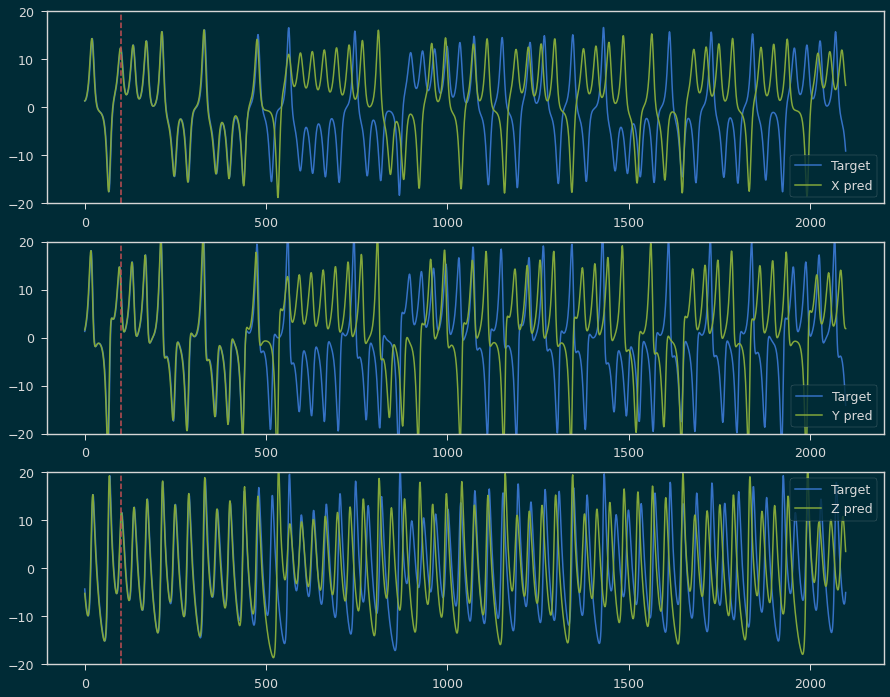

 Iter=67 a=0.680 sr=1.427 amp=0.919  ri=0.007 rr=0.990 loss=0.939497


Iter: 67 #### Diagnostic 0.939497   Time 6.38  Best 0.939 NRMSE 0.243 CD 0.696
Iter: 68 #### Diagnostic 1000.000000   Time 4.77  Best 0.939 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.59  Best 0.939 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.63  Best 0.939 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.89  Best 0.939 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 4.44  Best 0.939 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.368600   Time 5.16  Best 0.939 NRMSE 0.300 CD 1.069
Iter: 74 #### Diagnostic 1000.000000   Time 5.17  Best 0.939 NRMSE 256289918824898201911296.000 CD 1.000
Iter: 75 #### Diagnostic 1000.000000   Time 4.87  Best 0.939 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.196570   Time 4.65  Best 0.939 NRMSE 0.301 CD 0.896
Iter: 77 #### Diagnostic 2.576230   Time 5.63  Best 0.939 NRMSE 1.568 CD 1.008
Iter: 78 #

Iter: 61 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 37838794506453384498126642021924864.000 CD 1.000
Iter: 66 #### Diagnostic 1000.000000   Time 4.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.299197   Time 4.59  Best 1000.000 NRMSE 0.315 CD 0.985
Iter: 68 #### Diagnostic 1000.000000   Time 4.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.344343   Time 5.42  Best 1000.000 NRMSE 0.300 CD 1.045
Iter: 72 #### Diagnostic 1000

Iter: 48 #### Diagnostic 1.381289   Time 5.11  Best 1000.000 NRMSE 0.319 CD 1.062
Iter: 49 #### Diagnostic 12.899890   Time 4.93  Best 1000.000 NRMSE 11.783 CD 1.117
Iter: 50 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.95  Best 1000.000 NRMSE 585471790287024383426822144.000 CD 1.000
Iter: 56 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.635846  

Iter: 41 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.22  Best 1000.000 NRMSE 6294016026032193536.000 CD 1.000
Iter: 49 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000 

Iter: 34 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.457261   Time 6.52  Best 1000.000 NRMSE 0.292 CD 1.165
Iter: 36 #### Diagnostic 1.249673   Time 5.16  Best 1000.000 NRMSE 0.263 CD 0.986
Iter: 37 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.93  Best 1000.00

Iter: 27 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.555034   Time 4.87  Best 1000.000 NRMSE 0.320 CD 1.235
Iter: 30 #### Diagnostic 1.453280   Time 5.00  Best 1000.000 NRMSE 0.385 CD 1.068
Iter: 31 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 131413927741936659070976.000 CD 1.000
Iter: 32 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 4.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   T

Iter: 20 #### Diagnostic 1.312924   Time 4.70  Best 1000.000 NRMSE 0.307 CD 1.006
Iter: 21 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 290910111986419782066074812416.000 CD 1.000
Iter: 23 #### Diagnostic 1000.000000   Time 4.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 452058815848436876423657745809408.000 CD 1.000
Iter: 28 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.482417   Time 4.53  Best 1000.000 NRMSE 0.304 CD 1.179
Iter: 30 #### Diagnostic 1.405795   Time 4.79  Best 1000.000 NRMSE 0.287 CD 1.119
Iter: 3

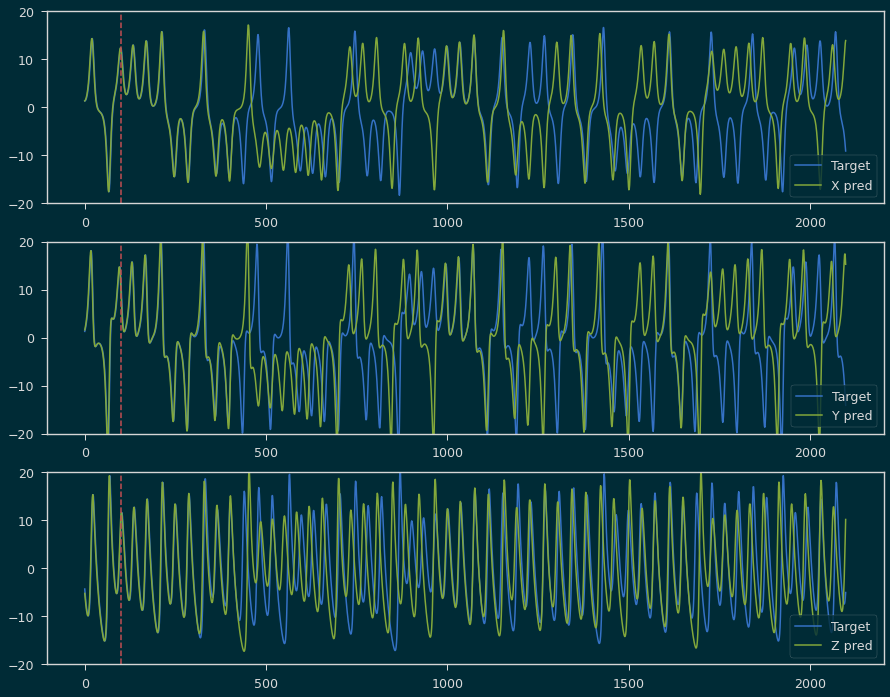

 Iter=75 a=0.617 sr=1.396 amp=0.995  ri=0.021 rr=1.022 loss=0.887866


Iter: 75 #### Diagnostic 0.887866   Time 6.21  Best 0.888 NRMSE 0.212 CD 0.676
Iter: 76 #### Diagnostic 1000.000000   Time 4.85  Best 0.888 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.394555   Time 5.34  Best 0.888 NRMSE 0.338 CD 1.057
Iter: 78 #### Diagnostic 1000.000000   Time 4.89  Best 0.888 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.79  Best 0.888 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 4.81  Best 0.888 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 4.50  Best 0.888 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 5.03  Best 0.888 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.259235   Time 4.80  Best 0.888 NRMSE 0.291 CD 0.968
Iter: 84 #### Diagnostic 1000.000000   Time 5.54  Best 0.888 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.503940   Time 4.93  Best 0.888 NRMSE 0.287 CD 1.217
Iter: 86 #### Diagnostic 1000.00

Iter: 62 #### Diagnostic 1000.000000   Time 7.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 7.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 2.319035   Time 7.26  Best 1000.000 NRMSE 1.326 CD 0.993
Iter: 65 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 9.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 46.832648   Time 8.03  Best 1000.000 NRMSE 45.830 CD 1.003
Iter: 70 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.476924   Time 7.39  Best 1000.000

Iter: 56 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.412369   Time 8.02  Best 1000.000 NRMSE 0.348 CD 1.065
Iter: 60 #### Diagnostic 2.165642   Time 8.13  Best 1000.000 NRMSE 1.067 CD 1.099
Iter: 61 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.657285   Time 6.62  Best 1000.000 NRMSE 0.346 CD 1.312
Iter: 64 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 2872871009455147008.000 CD 1.000
Iter: 65 #### Diagnostic 1.174513   Time 8.56  Best 1000.000 NRMSE 0.283 CD 0.892
Iter: 66 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.14  Bes

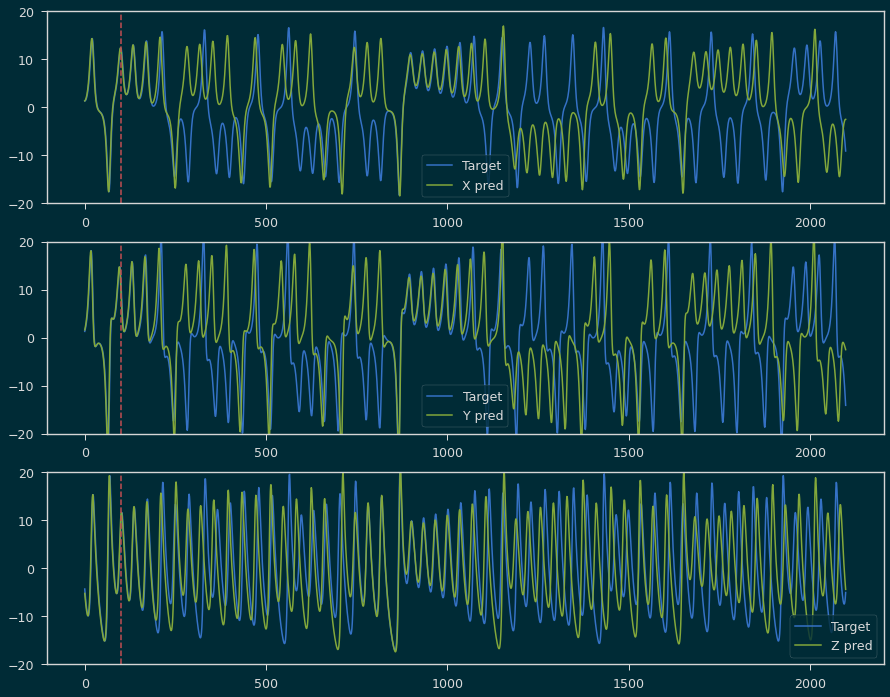

 Iter=99 a=0.591 sr=1.420 amp=0.940  ri=0.010 rr=1.078 loss=0.881050


Iter: 99 #### Diagnostic 0.881050   Time 8.40  Best 0.881 NRMSE 0.226 CD 0.655

Run: 1 Best result = 0.881049897799665
a = 0.5913973831093189
sr = 1.4200502688701213
amp = 0.9398910680782465
ri = 0.009608540869300571
rr = 1.0782916298581136
********** Size40 ref 2 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 33180482112660717683747866999259136.000 CD 1.000
Iter: 1 #### Diagnostic 1000.000000   Time 8.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.353281   Time 6.64  Best 1000.000 NRMSE 0.408 CD 0.945
Iter: 3 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.095035   Time 6.81  Best 1000.000 NRMSE 0.272 CD 0.824
Iter: 5 #### Diagnostic 1.162543   Time 6.66  Best 1000.000 NRMSE 0.277 CD 0.886
Iter: 6 #### Diagnostic 1000.000000   Time 8.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 100

Iter: 91 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 111327081733157044224.000 CD 1.000
Iter: 96 #### Diagnostic 1000.000000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.291216   Time 5.69  Best 1000.000 NRMSE 0.291 CD 1.000
Iter: 98 #### Diagnostic 1.424403   Time 7.56  Best 1000.000 NRMSE 0.345 CD 1.079
Iter: 99 #### Diagnostic 0.999147   Time 5.75  Best 1000.000 NRMSE 0.257 CD 0.742

Run: 2 Best result = 0.999147391244749
a = 0.5508930318782734
sr = 1.147571261986458
amp = 0.9405355625447726
ri = 0.33364052389982146
rr = 0.9870875777389752
********** Size40 ref 2 -- Run 3 ***********
Iter: 0 #### D

Iter: 85 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.366348   Time 6.84  Best 1000.000 NRMSE 0.310 CD 1.057
Iter: 88 #### Diagnostic 1.342617   Time 8.69  Best 1000.000 NRMSE 0.295 CD 1.047
Iter: 89 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 8.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 7.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.602242   Time 7.23  Best 1000.000 NRMSE 0.364 CD 1.238
Iter: 93 #### Diagnostic 1.590456   Time 6.49  Best 1000.000 NRMSE 0.296 CD 1.295
Iter: 94 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.877168   Time 5.65  Best 1000.000 NRMSE 0.889 CD 0.989
Iter: 96 #### Diagnostic 1.447018   Time 6.70  Best 1000.000 NRMSE 0.436 C

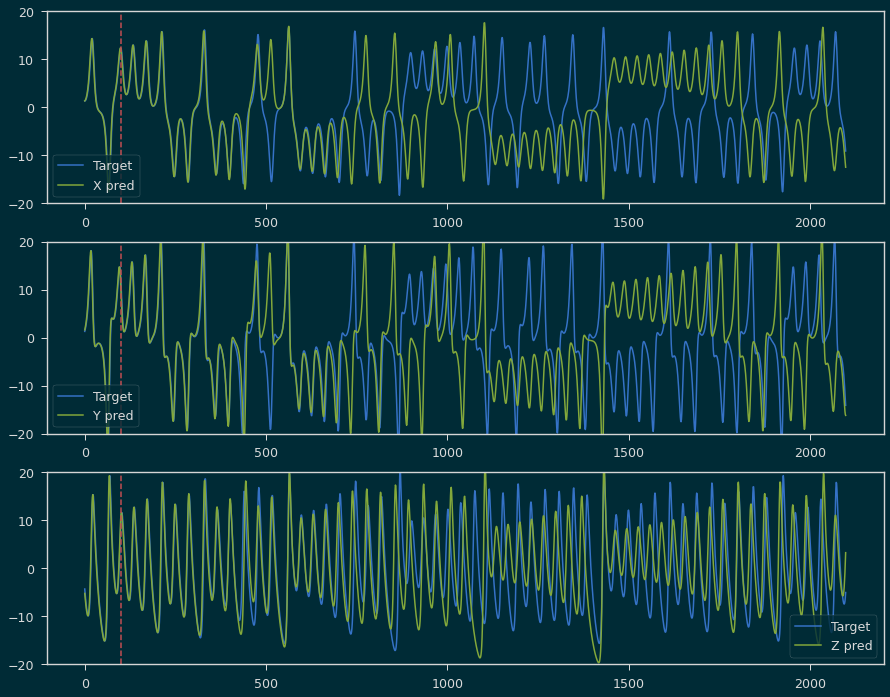

 Iter=75 a=0.617 sr=1.396 amp=0.995  ri=0.021 rr=1.022 loss=0.728289


Iter: 75 #### Diagnostic 0.728289   Time 10.20  Best 0.728 NRMSE 0.209 CD 0.519
Iter: 76 #### Diagnostic 1000.000000   Time 5.91  Best 0.728 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 7.84  Best 0.728 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 7.77  Best 0.728 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 7.96  Best 0.728 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.47  Best 0.728 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.397571   Time 7.02  Best 0.728 NRMSE 0.342 CD 1.055
Iter: 82 #### Diagnostic 5.575212   Time 5.83  Best 0.728 NRMSE 4.460 CD 1.115
Iter: 83 #### Diagnostic 1.362485   Time 6.65  Best 0.728 NRMSE 0.307 CD 1.055
Iter: 84 #### Diagnostic 1000.000000   Time 7.27  Best 0.728 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.177118   Time 6.62  Best 0.728 NRMSE 0.278 CD 0.900
Iter: 86 #### Diagnostic 0.961372  

Iter: 63 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.381123   Time 8.07  Best 1000.000 NRMSE 0.317 CD 1.064
Iter: 68 #### Diagnostic 1000.000000   Time 8.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 8.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.465310   Time 6.12  Best 1000.000 NRMSE 0.386 CD 1.079
Iter: 71 #### Diagnostic 1.345662   Time 8.09  Best 1000.000 NRMSE 0.302 CD 1.044
Iter: 72 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 7.18  Best 1000.000 NRMSE 1342222506.365 CD 1.079
Iter: 74 #### Diagnostic 1000.000000   Time 6.46  Best 100

Iter: 55 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 487.759052   Time 7.38  Best 1000.000 NRMSE 486.737 CD 1.022
Iter: 57 #### Diagnostic 1.497344   Time 9.06  Best 1000.000 NRMSE 0.399 CD 1.098
Iter: 58 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.381034   Time 6.91  Best 1000.000 NRMSE 0.317 CD 1.064
Iter: 60 #### Diagnostic 2.084236   Time 8.27  Best 1000.000 NRMSE 1.086 CD 0.998
Iter: 61 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 8.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.348511   Time 8.46  Best 1000.000 NRMSE 0.275 CD 1.073
Iter: 65 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 10.27  Best 1000.000 NRMSE

Iter: 49 #### Diagnostic 1.475105   Time 9.16  Best 1000.000 NRMSE 0.295 CD 1.180
Iter: 50 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.321634   Time 8.81  Best 1000.000 NRMSE 0.295 CD 1.027
Iter: 52 #### Diagnostic 1.541511   Time 7.15  Best 1000.000 NRMSE 0.298 CD 1.243
Iter: 53 #### Diagnostic 1000.000000   Time 8.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.427320   Time 8.31  Best 1000.000 NRMSE 0.296 CD 1.131
Iter: 55 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.400114   Time 9.15  Best 1000.000 NRMSE 0.331 CD 1.069


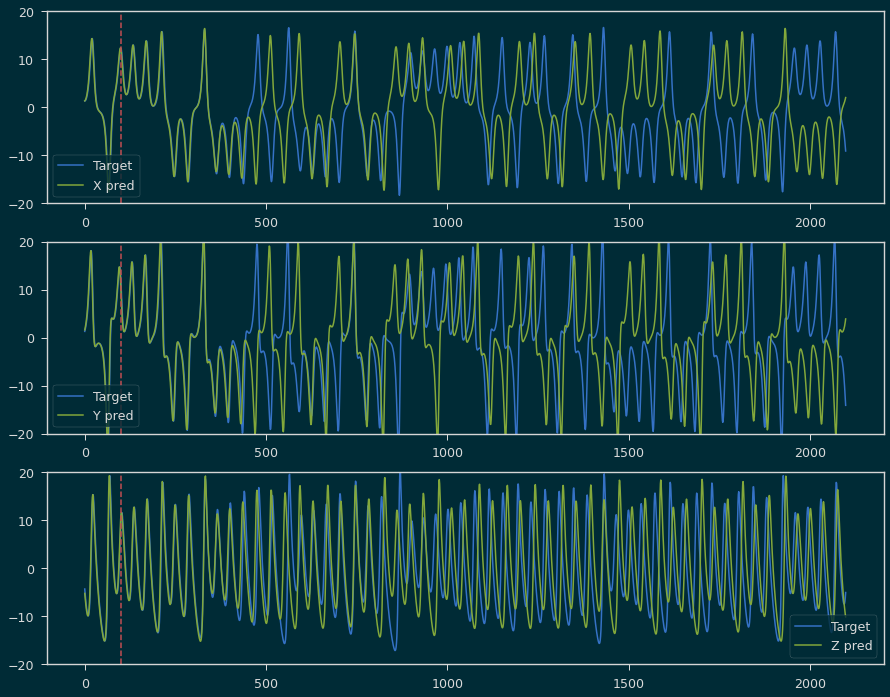

 Iter=57 a=0.584 sr=1.429 amp=0.997  ri=0.024 rr=1.008 loss=0.791957


Iter: 57 #### Diagnostic 0.791957   Time 8.40  Best 0.792 NRMSE 0.218 CD 0.574
Iter: 58 #### Diagnostic 1000.000000   Time 7.87  Best 0.792 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.303971   Time 7.65  Best 0.792 NRMSE 0.304 CD 1.000
Iter: 60 #### Diagnostic 1000.000000   Time 6.61  Best 0.792 NRMSE 30227201529115173011324928.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 8.23  Best 0.792 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.01  Best 0.792 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.621950   Time 5.85  Best 0.792 NRMSE 0.530 CD 1.092
Iter: 64 #### Diagnostic 1.374741   Time 5.45  Best 0.792 NRMSE 0.320 CD 1.055
Iter: 65 #### Diagnostic 1000.000000   Time 9.19  Best 0.792 NRMSE 13248040634462761203682770944.000 CD 1.000
Iter: 66 #### Diagnostic 1000.000000   Time 5.63  Best 0.792 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 8.75  Best 0.792 NRM

Iter: 51 #### Diagnostic 1.507213   Time 6.72  Best 1000.000 NRMSE 0.330 CD 1.177
Iter: 52 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1390526240543765111192092458090496.000 CD 1.000
Iter: 53 #### Diagnostic 1.621269   Time 7.30  Best 1000.000 NRMSE 0.441 CD 1.180
Iter: 54 #### Diagnostic 1.381396   Time 6.44  Best 1000.000 NRMSE 0.332 CD 1.050
Iter: 55 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 8.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.0000

Iter: 44 #### Diagnostic 1000.000000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.131262   Time 7.16  Best 1000.000 NRMSE 0.275 CD 0.856
Iter: 46 #### Diagnostic 1.407311   Time 7.86  Best 1000.000 NRMSE 0.319 CD 1.089
Iter: 47 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.313660   Time 4.42  Best 1000.000 NRMSE 0.297 CD 1.017
Iter: 54 #### Diagnostic 1.180166   Time 6.73  Best 1000.000 NRMSE 0.304 CD 0.877
Iter: 55 #### Diagnostic 1000.000000   Time 6.59  Best 1000.000 NRMSE 

Iter: 31 #### Diagnostic 1.519159   Time 7.58  Best 1000.000 NRMSE 0.475 CD 1.044
Iter: 32 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.172196   Time 6.78  Best 1000.000 NRMSE 0.267 CD 0.905
Iter: 35 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 48589472973600304.000 CD 1.000
Iter: 37 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.538571   Time 5.51  

Iter: 24 #### Diagnostic 1000.000000   Time 8.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 16527334494.462 CD 1.076
Iter: 29 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.660180   Time 7.61  Best 1000.000 NRMSE 0.332 CD 1.328
Iter: 33 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 7.39 

Iter: 17 #### Diagnostic 1000.000000   Time 7.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.571058   Time 6.16  Best 1000.000 NRMSE 0.399 CD 1.172
Iter: 19 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 23444272089786984.000 CD 1.000
Iter: 20 #### Diagnostic 1000.000000   Time 9.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.315150   Time 6.60  Best 1000.000 NRMSE 0.290 CD 1.026
Iter: 25 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 40504587145553520.000 CD 1.008
Iter: 28 #### Diagnostic 1000.00

Iter: 10 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.253188   Time 7.56  Best 1000.000 NRMSE 0.269 CD 0.985
Iter: 17 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.519689   Time 6.78  Best 1000.000 NRMSE 0.544 CD 0.976
Iter: 19 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 7.22  Best 1000.00

Iter: 2 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 29490945470564963188736.000 CD 1.000
Iter: 5 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 8.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.188929   Time 6.90  Best 1000.000 NRMSE 0.309 CD 0.880
Iter: 10 #### Diagnostic 1000.000000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 444049763611815837696.000 CD 1.000
Iter: 13 #### Diagnostic 1

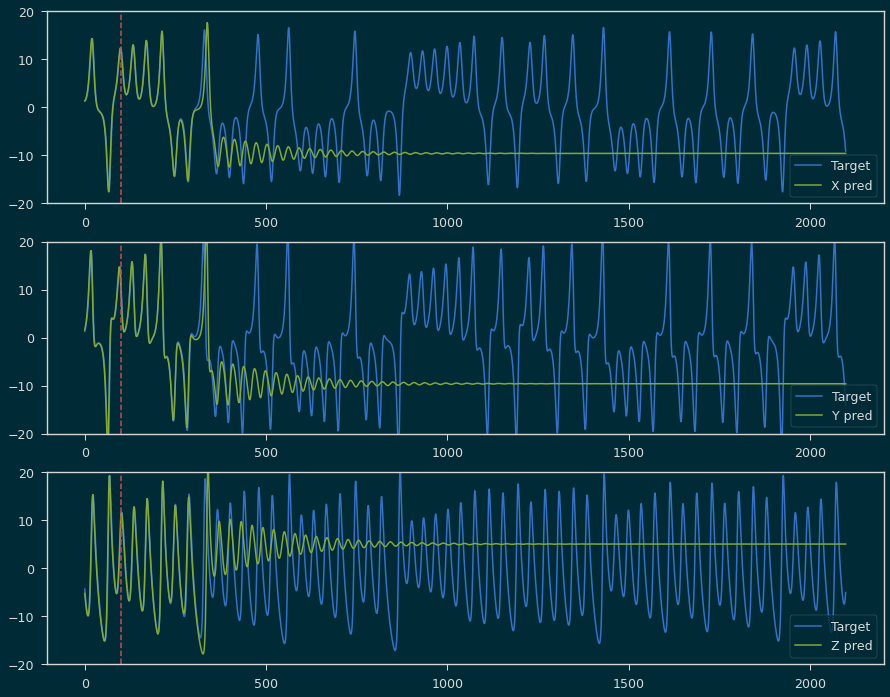

 Iter=85 a=0.627 sr=1.308 amp=0.955  ri=0.028 rr=0.924 loss=0.949772


Iter: 85 #### Diagnostic 0.949772   Time 9.37  Best 0.950 NRMSE 0.263 CD 0.687
Iter: 86 #### Diagnostic 1.272935   Time 6.84  Best 0.950 NRMSE 0.292 CD 0.981
Iter: 87 #### Diagnostic 1000.000000   Time 6.98  Best 0.950 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.40  Best 0.950 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.65  Best 0.950 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 7.71  Best 0.950 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.572104   Time 7.04  Best 0.950 NRMSE 0.397 CD 1.175
Iter: 92 #### Diagnostic 1000.000000   Time 7.31  Best 0.950 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.405135   Time 7.18  Best 0.950 NRMSE 0.319 CD 1.086
Iter: 94 #### Diagnostic 1000.000000   Time 8.26  Best 0.950 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 8.44  Best 0.950 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.00

Iter: 71 #### Diagnostic 1000.000000   Time 6.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 2.196823   Time 7.63  Best 1000.000 NRMSE 1.102 CD 1.095
Iter: 73 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.462464   Time 5.81  Best 1000.000 NRMSE 0.409 CD 1.053
Iter: 75 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.374876   Time 7.29  Best 1000.000 NRMSE 0.307 CD 1.068
Iter: 77 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.367978   Time 7.97  Best 1000.000 NRMSE 0.304 CD 1.064
Iter: 82 #### Diagnostic 1000.000000   Time 7.70  Best 1000.000 NRMSE 

Iter: 65 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.362934   Time 8.55  Best 1000.000 NRMSE 0.305 CD 1.058
Iter: 67 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.72  Best 1000.000 NRMSE 31695264129486385152.000 CD 1.000
Iter: 70 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.473097   Time 6.22  Best 1000.000 NRMSE 0.372 CD 1.101
Iter: 72 #### Diagnostic 32.207313   Time 7.28  Best 1000.000 NRMSE 31.121 CD 1.086
Iter: 73 #### Diagnostic 1.316172   Time 6.43  Best 1000.000 NRMSE 0.294 CD 1.022
Iter: 74 #### Diagnostic 1000.000000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.71  

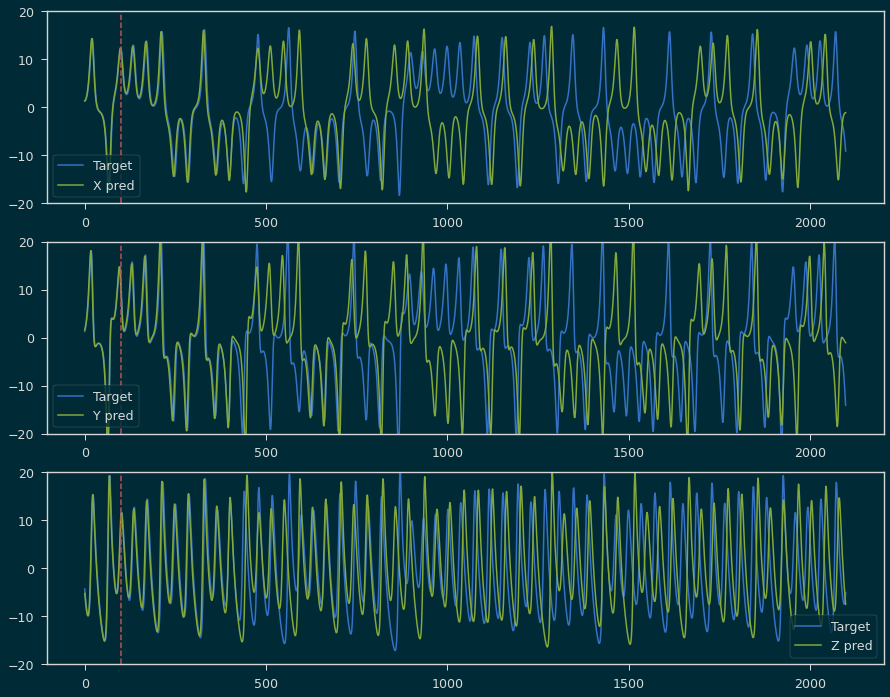

 Iter=99 a=0.591 sr=1.420 amp=0.940  ri=0.010 rr=1.078 loss=0.818528


Iter: 99 #### Diagnostic 0.818528   Time 8.30  Best 0.819 NRMSE 0.222 CD 0.596

Run: 1 Best result = 0.8185279124843712
a = 0.5913973831093189
sr = 1.4200502688701213
amp = 0.9398910680782465
ri = 0.009608540869300571
rr = 1.0782916298581136
********** Size30 ref 0 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 8.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.177854   Time 8.75  B

Iter: 92 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.578137   Time 6.44  Best 1000.000 NRMSE 0.568 CD 1.010
Iter: 98 #### Diagnostic 1.774166   Time 7.06  Best 1000.000 NRMSE 0.757 CD 1.017
Iter: 99 #### Diagnostic 1000.000000   Time 8.39  Best 1000.000 NRMSE 1000.000 CD nan

Run: 2 Best result = 1.1778535625647941
a = 0.5827437365850968
sr = 1.2690677279544222
amp = 0.9713565747153496
ri = 0.010223908951854307
rr = 0.9631534493066668
********** Size30 ref 0 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.3

Iter: 86 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.381390   Time 9.25  Best 1000.000 NRMSE 0.297 CD 1.084
Iter: 88 #### Diagnostic 1.457874   Time 6.37  Best 1000.000 NRMSE 0.390 CD 1.068
Iter: 89 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 8.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 7.43  Best 1000.00

Iter: 80 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.472231   Time 6.80  Best 1000.000 NRMSE 0.346 CD 1.126
Iter: 82 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.542071   Time 7.11  Best 1000.000 NRMSE 0.332 CD 1.210
Iter: 84 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.568758   Time 6.92  Best 1000.000 NRMSE 0.494 CD 1.075
Iter: 86 #### Diagnostic 1000.000000   Time 7.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.168457   Time 7.50  Best 1000.000 NRMSE 0.279 CD 0.890
Iter: 88 #### Diagnostic 1000.000000   Time 7.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.544006   Time 5.79  Best 1000.000 NRMSE 0.424 CD 1.120
Iter: 91 #### Diagnostic 1000.000000   Time 8.57  Best 1000.000 NRMSE 1000

Iter: 67 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.303704   Time 7.09  Best 1000.000 NRMSE 0.316 CD 0.988
Iter: 70 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.294561   Time 6.31  Best 1000.000 NRMSE 0.289 CD 1.005
Iter: 78 #### Diagnostic 1.878621   Time 6.68  Best 1000.000 N

Iter: 61 #### Diagnostic 1.358791   Time 5.80  Best 1000.000 NRMSE 0.302 CD 1.057
Iter: 62 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 6.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.46  Best 1000.000 NRMSE 28646863982186807296.000 CD 1.000
Iter: 69 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.311143   Time 6.05  Best 1000.000 NRMSE 0.290 CD 1.021
Iter: 71 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 

Iter: 54 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 121704687023023636611072.000 CD 1.000
Iter: 56 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.290337   Time 9.24  Best 1000.000 NRMSE 0.300 CD 0.991
Iter: 58 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 6.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 2.085125   

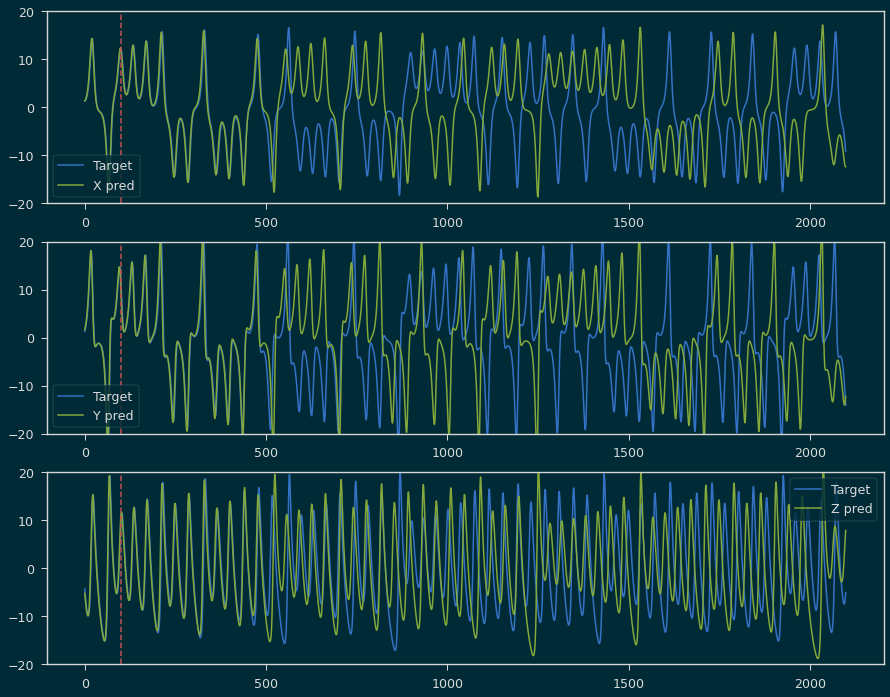

 Iter=34 a=0.532 sr=1.182 amp=0.999  ri=0.024 rr=1.001 loss=0.940789


Iter: 34 #### Diagnostic 0.940789   Time 8.51  Best 0.941 NRMSE 0.243 CD 0.697
Iter: 35 #### Diagnostic 1.431663   Time 8.18  Best 0.941 NRMSE 0.359 CD 1.072
Iter: 36 #### Diagnostic 1000.000000   Time 7.95  Best 0.941 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 7.42  Best 0.941 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.394736   Time 7.18  Best 0.941 NRMSE 0.322 CD 1.072
Iter: 39 #### Diagnostic 1.299165   Time 5.15  Best 0.941 NRMSE 0.364 CD 0.935
Iter: 40 #### Diagnostic 1000.000000   Time 8.09  Best 0.941 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 6.29  Best 0.941 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 2.028182   Time 6.05  Best 0.941 NRMSE 0.972 CD 1.056
Iter: 43 #### Diagnostic 1.232734   Time 8.52  Best 0.941 NRMSE 0.291 CD 0.941
Iter: 44 #### Diagnostic 1000.000000   Time 7.03  Best 0.941 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   T

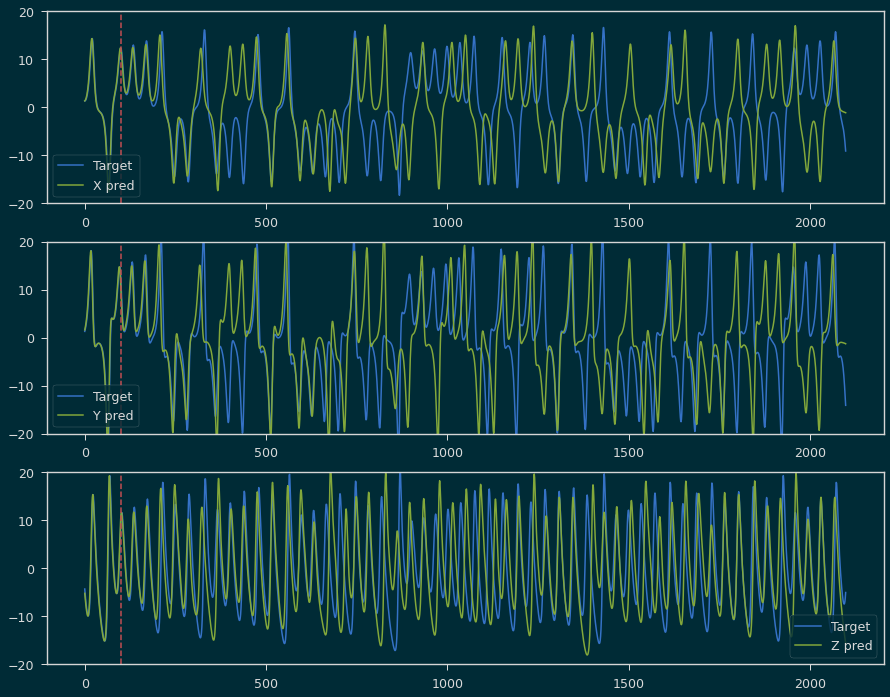

 Iter=58 a=0.639 sr=1.136 amp=0.984  ri=0.044 rr=1.081 loss=0.929189


Iter: 58 #### Diagnostic 0.929189   Time 9.88  Best 0.929 NRMSE 0.227 CD 0.702
Iter: 59 #### Diagnostic 1000.000000   Time 7.95  Best 0.929 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.84  Best 0.929 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.92  Best 0.929 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 8.65  Best 0.929 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 6.48  Best 0.929 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.47  Best 0.929 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 7.38  Best 0.929 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 8.43  Best 0.929 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.97  Best 0.929 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.95  Best 0.929 NRMSE 1000.000 CD nan
Iter: 69 #### Diagno

Iter: 52 #### Diagnostic 1.387950   Time 5.33  Best 1000.000 NRMSE 0.314 CD 1.073
Iter: 53 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.123773   Time 7.03  Best 1000.000 NRMSE 0.226 CD 0.898
Iter: 56 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 594872981154883584.000 CD 1.000
Iter: 58 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 6.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.375362   Time 6.40  Best 1000.000 NRMSE 0.426 CD 0.949
Iter: 62 #### Diagnostic 1.430328   Time 7.39  Best 1000.000 NRMSE 0.362 CD 1.068
Iter: 63 #### Diagnostic 1000.000000   Time 8.64  Best

Iter: 39 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 3651421606350098006016.000 CD 1.000
Iter: 40 #### Diagnostic 1000.000000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.241785   Time 8.82  Best 1000.000 NRMSE 0.250 CD 0.992
Iter: 44 #### Diagnostic 1.362070   Time 6.00  Best 1000.000 NRMSE 0.307 CD 1.055
Iter: 45 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 8.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 9.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 5.700541   Time 5.89  Best 1000.000 NRMSE 4.613 CD 1.087
Iter: 50 #### Diagnostic 1000.000000   Time 7.

Iter: 32 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.464120   Time 6.68  Best 1000.000 NRMSE 0.365 CD 1.099
Iter: 36 #### Diagnostic 1000.000000   Time 7.70  Best 1000.000 NRMSE 68036200194734311782481920.000 CD 1.000
Iter: 37 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 8.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.467080   Time 5.71  Best 1000.000 NRMSE 0.353 CD 1.114
Iter: 41 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000  

Iter: 25 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.003100   Time 7.49  Best 1000.000 NRMSE 0.232 CD 0.771
Iter: 29 #### Diagnostic 1.475781   Time 6.11  Best 1000.000 NRMSE 0.611 CD 0.864
Iter: 30 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 3809221557671982801092608.000 CD 1.000
Iter: 31 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 8.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.400716   Time 7.10  Best 1000.000 NRMSE 0.338 CD 1.063
Iter: 36 #### Diagnostic 1000.000000   Time

Iter: 18 #### Diagnostic 1.361191   Time 6.18  Best 1000.000 NRMSE 0.311 CD 1.051
Iter: 19 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 7.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.201138   Time 7.18  Best 1000.000 NRMSE 0.309 CD 0.892
Iter: 24 #### Diagnostic 2.381308   Time 6.72  Best 1000.000 NRMSE 1.333 CD 1.049
Iter: 25 #### Diagnostic 1.815959   Time 6.35  Best 1000.000 NRMSE 0.745 CD 1.070
Iter: 26 #### Diagnostic 1.403566   Time 5.42  Best 1000.000 NRMSE 0.294 CD 1.109
Iter: 27 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.433386   Time 6.62  Best 1000.000 NRMSE 0.347 CD 1.086
Iter: 29 #### Diagnostic 3.344113   Time 8.40  Best 1000.000 NRMSE 2.266 CD 1.

Iter: 12 #### Diagnostic 1.374436   Time 8.14  Best 1000.000 NRMSE 0.310 CD 1.064
Iter: 13 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 7028235056.289 CD 1.034
Iter: 17 #### Diagnostic 3.247568   Time 8.29  Best 1000.000 NRMSE 2.135 CD 1.113
Iter: 18 #### Diagnostic 1.574753   Time 7.60  Best 1000.000 NRMSE 0.346 CD 1.228
Iter: 19 #### Diagnostic 1000.000000   Time 8.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.265564   Time 10.07  Best 1000.000 NRMSE 0.292 CD 0.973
Iter: 23 #### Diagnostic 1.376713   Time 5.84  Best 1000.000 

Iter: 2 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.325189   Time 8.40  Best 1000.000 NRMSE 0.357 CD 0.969
Iter: 4 #### Diagnostic 1.345753   Time 7.51  Best 1000.000 NRMSE 0.442 CD 0.904
Iter: 5 #### Diagnostic 1.488865   Time 6.41  Best 1000.000 NRMSE 0.369 CD 1.120
Iter: 6 #### Diagnostic 1000.000000   Time 7.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.337279   Time 6.63  Best 1000.000 NRMSE 0.332 CD 1.005
Iter: 8 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.204664   Time 7.03  Best 1000.000 NRMSE 0.308 CD 0.896
Iter: 10 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.473293   Time 7.73  Best 1000.000 NRMSE 0.450 CD 1.023
Iter: 12 #### Diagnostic 1.352687   Time 6.78  Best 1000.000 NRMSE 0.375 CD 0.978
Iter: 13 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 99 #### Diagnostic 1.211840   Time 7.86  Best 1000.000 NRMSE 0.294 CD 0.918

Run: 0 Best result = 1.2046635953890448
a = 0.6847699713559465
sr = 1.1759011754363051
amp = 0.998825679564939
ri = 0.1883866774452155
rr = 1.0647072279691971
********** Size30 ref 3 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.248976   Time 7.74  Best 1000.000 NRMSE 0.288 CD 0.961
Iter: 5 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.507919   Time 6.79  Best 1000.000 NRMSE 0.459 CD 1.049
Iter: 7 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Tim

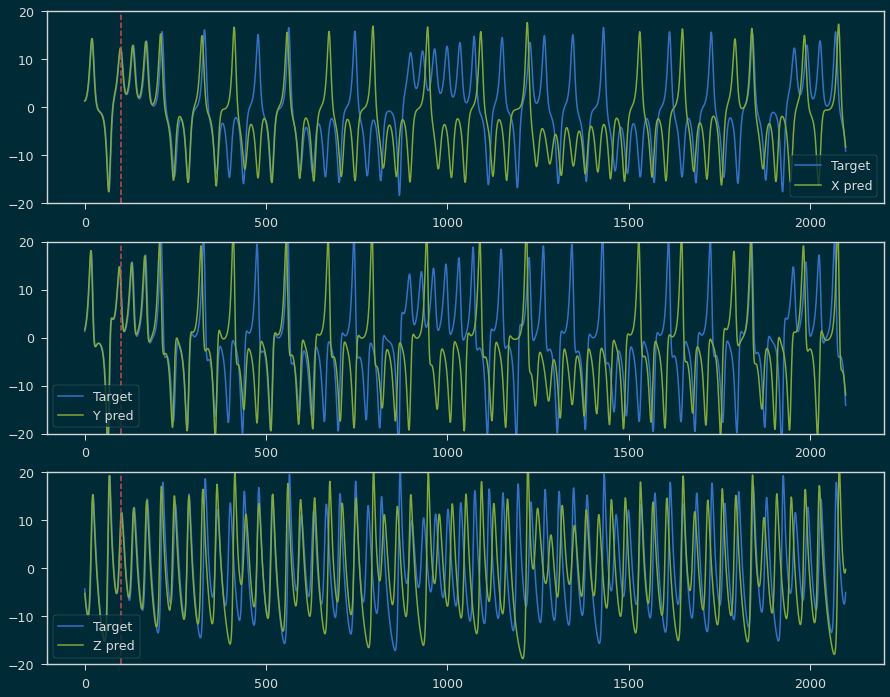

 Iter=66 a=0.549 sr=1.290 amp=0.961  ri=0.013 rr=0.996 loss=0.935438


Iter: 66 #### Diagnostic 0.935438   Time 8.75  Best 0.935 NRMSE 0.244 CD 0.691
Iter: 67 #### Diagnostic 1000.000000   Time 8.48  Best 0.935 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.490159   Time 8.68  Best 0.935 NRMSE 0.318 CD 1.173
Iter: 69 #### Diagnostic 1.594219   Time 5.34  Best 0.935 NRMSE 0.607 CD 0.987
Iter: 70 #### Diagnostic 1000.000000   Time 7.50  Best 0.935 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 6.83  Best 0.935 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.28  Best 0.935 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 8.00  Best 0.935 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.89  Best 0.935 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 8.02  Best 0.935 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.12  Best 0.935 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 100

Iter: 59 #### Diagnostic 1000.000000   Time 8.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.532520   Time 7.99  Best 1000.000 NRMSE 0.441 CD 1.092
Iter: 64 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 7883405846517733376.000 CD 1.000
Iter: 66 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 8.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.952906   Time 6.62  Best 1000.000 NRMSE 0.633 CD 1.320
Iter: 70 #### Diagnostic 1000.000000   Time 6

Iter: 52 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 7.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 2.678431   Time 6.83  Best 1000.000 NRMSE 1.498 CD 1.180
Iter: 59 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1142870347486587098028451121070080.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1

Iter: 46 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 273459646865425728389634297167872.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.360191   Time 6.77  Best 1000.000 NRMSE 0.318 CD 1.042
Iter: 54 #### Diagnostic 1000.000000   Time 7.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 312008303515.221 CD 1.043
Iter: 57 #### Dia

Iter: 32 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 116778.027 CD 1.025
Iter: 35 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.469359   Time 5.14  Best 1000.000 NRMSE 0.360 CD 1.109
Iter: 38 #### Diagnostic 1.367319   Time 6.71  Best 1000.000 NRMSE 0.311 CD 1.057
Iter: 39 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 2.451586   Time 6.38  Best 1000.000 NRMSE 1.375 CD 1.077
Iter: 41 #### Diagnostic 4.196367   Time 7.15  Best 1000.000 NRMSE 3.095 CD 1.102
Iter: 42 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NR

Iter: 25 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.481547   Time 7.91  Best 1000.000 NRMSE 0.297 CD 1.185
Iter: 29 #### Diagnostic 1.150107   Time 7.95  Best 1000.000 NRMSE 0.277 CD 0.873
Iter: 30 #### Diagnostic 1000.000000   Time 8.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 7.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.485503   Time 9.59  Best 1000.000 NRMSE 0.362 CD 1.123
Iter: 33 #### Diagnostic 1.458955   Time 5.80  Best 1000.000 NRMSE 0.426 CD 1.033
Iter: 34 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 4.261460   Time 7.36  Best 1000.000 NRMSE 3.219 CD 1.042
Iter: 36 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1979

Iter: 19 #### Diagnostic 4.266763   Time 6.65  Best 1000.000 NRMSE 3.171 CD 1.096
Iter: 20 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.539628   Time 6.53  Best 1000.000 NRMSE 0.359 CD 1.181
Iter: 22 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.403742   Time 5.83  Best 1000.000 NRMSE 0.356 CD 1.048
Iter: 24 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.274017   Time 6.16  Best 1000.000 NRMSE 0.281 CD 0.993
Iter: 26 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.269100   Time 7.31  Best 1000.000 NRMSE 0.298 CD 0.971
Iter: 29 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000

Iter: 13 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.429246   Time 5.45  Best 1000.000 NRMSE 0.384 CD 1.045
Iter: 16 #### Diagnostic 1000.000000   Time 4.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.424188   Time 7.53  Best 1000.000 NRMSE 0.315 CD 1.109
Iter: 21 #### Diagnostic 1.484625   Time 5.81  Best 1000.000 NRMSE 0.386 CD 1.099
Iter: 22 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NR

Iter: 6 #### Diagnostic 1000.000000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 8.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.550412   Time 7.53  Best 1000.000 NRMSE 0.517 CD 1.034
Iter: 14 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.63  Best 1000.00

Iter: 0 #### Diagnostic 1.301200   Time 6.09  Best 1000.000 NRMSE 0.289 CD 1.012
Iter: 1 #### Diagnostic 1.367577   Time 8.14  Best 1000.000 NRMSE 0.289 CD 1.078
Iter: 2 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 139704850.783 CD 1.053
Iter: 3 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 N

Iter: 96 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.384831   Time 6.01  Best 1000.000 NRMSE 0.325 CD 1.059

Run: 0 Best result = 1.2640062322583892
a = 0.5778588408571989
sr = 0.964071053109756
amp = 0.9548984992643174
ri = 0.15888162865250885
rr = 0.9818671661153866
********** Size20 ref 0 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.499220   Time 7.62  Best 1000.000 NRMSE 0.423 CD 1.076
Iter: 5 #### Diagnostic 1000.0000

Iter: 90 #### Diagnostic 1000.000000   Time 6.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.529301   Time 7.46  Best 1000.000 NRMSE 0.337 CD 1.192
Iter: 97 #### Diagnostic 1000.000000   Time 7.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 2.561144   Time 6.64  Best 1000.000 NRMSE 1.584 CD 0.977

Run: 1 Best result = 1.0506274921528371
a = 0.5494494840140657
sr = 1.2898212902241368
amp = 0.9608308943479542
ri = 0.013422437170543873
rr = 0.99

Iter: 84 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.382965   Time 6.67  Best 1000.000 NRMSE 0.284 CD 1.099
Iter: 86 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.278128   Time 6.53  Best 1000.000 NRMSE 0.289 CD 0.989
Iter: 89 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.701767   Time 6.38  Best 1000.000 NRMSE 0.582 CD 1.119
Iter: 91 #### Diagnostic 1.719024   Time 6.53  Best 1000.000 NRMSE 0.824 CD 0.895
Iter: 92 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 

Iter: 78 #### Diagnostic 1.370769   Time 5.97  Best 1000.000 NRMSE 0.289 CD 1.082
Iter: 79 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.378745   Time 6.87  Best 1000.000 NRMSE 0.320 CD 1.058
Iter: 85 #### Diagnostic 1000.000000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1342609.197 CD 1.018
Iter: 89 #### Diagnostic 1000.000000   Time 8.32  Best 10

Iter: 71 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.379257   Time 5.64  Best 1000.000 NRMSE 0.321 CD 1.058
Iter: 76 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 105190452.745 CD 1.029
Iter: 81 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 7.13  B

Iter: 62 #### Diagnostic 2.139432   Time 6.28  Best 1000.000 NRMSE 1.056 CD 1.084
Iter: 63 #### Diagnostic 1.378030   Time 5.66  Best 1000.000 NRMSE 0.399 CD 0.979
Iter: 64 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 144744566724273351312281698304.000 CD 1.000
Iter: 68 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 3.359113   Time 6.18  Best 1000.000 NRMSE 2.361 CD 0.998
Iter: 71 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.476095   Ti

Iter: 56 #### Diagnostic 5.506483   Time 8.90  Best 1000.000 NRMSE 4.474 CD 1.032
Iter: 57 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.407773   Time 7.43  Best 1000.000 NRMSE 0.304 CD 1.104
Iter: 60 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.519821   Time 5.58  Best 1000.000 NRMSE 0.436 CD 1.084
Iter: 62 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 6.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NR

Iter: 50 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.275658   Time 7.04  Best 1000.000 NRMSE 0.322 CD 0.953
Iter: 57 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 82.953821   Time 7.03  Best 1000.000 NRMSE 81.910 CD 1.044
Iter: 60 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 301682162253008576.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 

Iter: 43 #### Diagnostic 1.416385   Time 6.40  Best 1000.000 NRMSE 0.298 CD 1.118
Iter: 44 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.773412   Time 8.39  Best 1000.000 NRMSE 0.743 CD 1.030
Iter: 46 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.53  Best 1000.00

Iter: 38 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.454233   Time 7.09  Best 1000.000 NRMSE 0.309 CD 1.145
Iter: 42 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.500044   Time 5.08  Best 1000.000 NRMSE 0.366 CD 1.134
Iter: 44 #### Diagnostic 1.366511   Time 5.49  Best 1000.000 NRMSE 0.298 CD 1.069
Iter: 45 #### Diagnostic 1000.000000   Time 7.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.88  Best 1000.000 NR

Iter: 29 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.398937   Time 5.01  Best 1000.000 NRMSE 0.330 CD 1.069
Iter: 37 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.406584   Time 4.72  Best 1000.0

In [ ]:

CALLS = 100      
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped N=1000,900,800
size = [40,30,20,10]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .5, .7
    min_sr, max_sr = .6, 1.45
    min_g, max_g = .9, 1.
    min_ri, max_ri = .001, .4
    min_rr, max_rr = .9, 1.1
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} ref {ref} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nRun: {rn} Best result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')